# NEI Integration into `synthesizAR`
Integrating non-equilibrium ionization into `synthesizAR` framework. This notebook is for testing this new functionality. We'll create a basic AR model and model a few different ions to test this out.

In [204]:
import os
import glob
import sys
import subprocess
import logging
logging.basicConfig(level=logging.INFO)

from IPython.display import HTML
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
import seaborn as sns

import synthesizAR
from synthesizAR.atomic import EmissionModel
from synthesizAR.model_ext import EbtelInterface,calculate_free_energy
from synthesizAR.instruments import InstrumentHinodeEIS,InstrumentSDOAIA

%matplotlib inline

In [4]:
ar_root = '/data/datadrive2/ar_viz/nei_testing'

## Field and Loops

Extrapolate the field and trace the loops.

In [ ]:
crop = (u.Quantity([-140,90]*u.arcsec),u.Quantity([420,560]*u.arcsec))
resample = u.Quantity([100,100]*u.pixel)
field = synthesizAR.Skeleton('/home/wtb2/sunpy/data/hmi_m_45s_2013_01_01_07_35_15_tai_magnetogram.0.fits',
                             crop=crop,resample=resample)
zshape=50
zrange=u.Quantity([0.,150.]*u.arcsec)
field.extrapolate_field(zshape,zrange)

In [ ]:
field.extract_streamlines(50,loop_length_range=[1e+9,1e+11]*u.cm)

In [ ]:
field.make_loops()

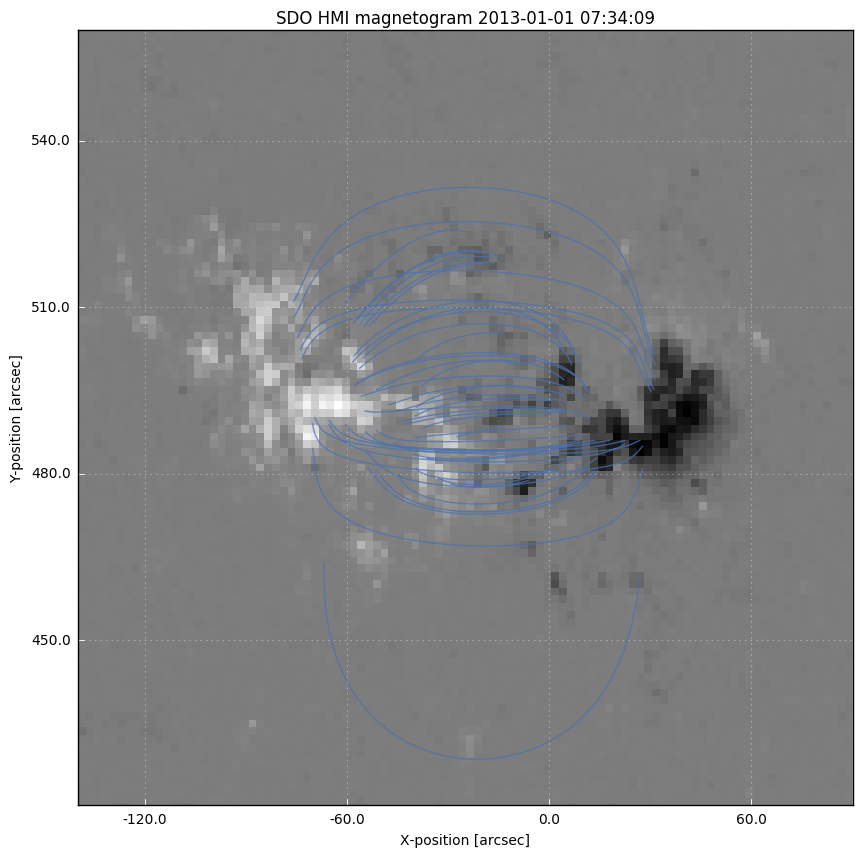

In [7]:
field.peek()

Configure the heating model for the loop.

In [ ]:
class NanoflareStormModel(object):
    def __init__(self,heating_options):
        self.heating_options = heating_options
        np.random.seed()
        
    @property
    def number_events(self):
        return 1
    
    def calculate_event_properties(self,loop):
        available_energy = calculate_free_energy(loop.field_aligned_coordinate,loop.field_strength,
                                                 stress_level=self.heating_options['stress_level'])
        rate = 2.0*available_energy/(self.number_events*(2.0*self.heating_options['duration'] 
                                                         - self.heating_options['duration_rise'] 
                                                         - self.heating_options['duration_decay']))
        #distribute start times randomly between 0 and total_time - duration
        tsr = np.random.rand(self.number_events)*(self.base_config['total_time'] - self.heating_options['duration'])
        ter = tsr + self.heating_options['duration_rise']
        tsd = ter + (self.heating_options['duration'] 
                     - self.heating_options['duration_rise'] 
                     - self.heating_options['duration_decay'])
        ted = tsr + self.heating_options['duration']
        return {'magnitude':np.array([rate]),'rise_start':tsr,'rise_end':ter,'decay_start':tsd,'decay_end':ted}

In [ ]:
heating_options = {
    'duration':200.0,
    'duration_rise':100.0,
    'duration_decay':100.0,
    'stress_level':0.1,
}
heating_model = NanoflareStormModel(heating_options)
ih = synthesizAR.util.InputHandler(os.path.join(os.environ['RESEARCH_DIR'],
                                                'ebtelPlusPlus/config/ebtel.example.cfg.xml'))
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['use_adaptive_solver'] = True
base_config['tau'] = 1.0
base_config['adaptive_solver_error'] = 1e-12
base_config['adaptive_solver_safety'] = 0.01
base_config['total_time'] = 5000.0
ebtel_plug = EbtelInterface(base_config,heating_model)

Run the loop simulations and import the results.

In [ ]:
field.configure_loop_simulations(ebtel_plug,
                                 parent_config_dir=os.path.join(ar_root,'hydro_config'),
                                 parent_results_dir=os.path.join(ar_root,'hydro_results'))

In [ ]:
for loop in field.loops:
    subprocess.call([os.path.join(os.environ['RESEARCH_DIR'],'ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

Load the results and save the field object.

In [ ]:
field.load_loop_simulations(ebtel_plug,savefile=os.path.join(ar_root,'loop_parameters.h5'))

In [ ]:
field.save(savedir=os.path.join(ar_root,'checkpoint'))

And restore it.

In [5]:
field = synthesizAR.Skeleton.restore(os.path.join(ar_root,'checkpoint'))

yt : [INFO     ] 2017-02-22 14:12:26,338 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-02-22 14:12:26,339 Parameters: domain_dimensions         = [96 96 46]
yt : [INFO     ] 2017-02-22 14:12:26,340 Parameters: domain_left_edge          = [ -9.60112377e+09   3.00297576e+10   4.25949509e+08]
yt : [INFO     ] 2017-02-22 14:12:26,341 Parameters: domain_right_edge         = [  6.06890905e+09   3.95486152e+10   1.02227882e+10]
yt : [INFO     ] 2017-02-22 14:12:26,342 Parameters: cosmological_simulation   = 0.0


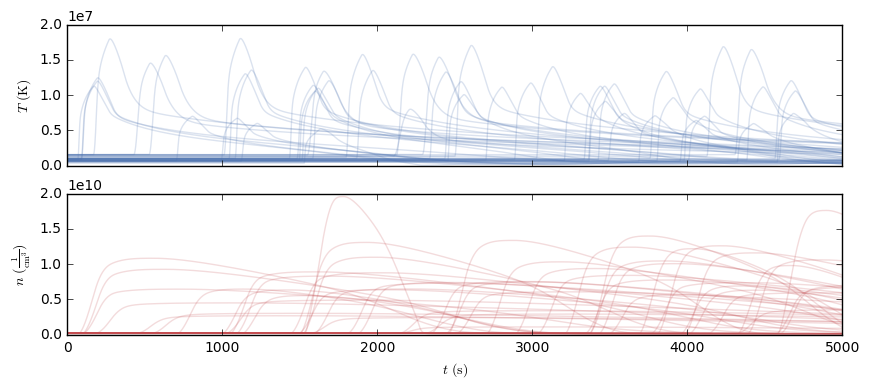

In [6]:
fig,axes = plt.subplots(2,1,figsize=(10,4),sharex=True)
for loop in field.loops:
    axes[0].plot(loop.time,loop.temperature[:,0],color=sns.color_palette('deep')[0],alpha=0.2)
    axes[1].plot(loop.time,loop.density[:,0],color=sns.color_palette('deep')[2],alpha=0.2)
axes[1].set_xlabel(r'$t$ $(${}$)$'.format(loop.time.unit.to_string(format='latex')))
axes[0].set_ylabel(r'$T$ $(${}$)$'.format(loop.temperature.unit.to_string(format='latex')))
axes[1].set_ylabel(r'$n$ $(${}$)$'.format(loop.density.unit.to_string(format='latex')))

## Emission Model
Create an emission model from a few ions, with at least two from the same element. These are taken from the line list given in [Warren et al. (2012)](http://iopscience.iop.org/article/10.1088/0004-637X/759/2/141/meta).

In [ ]:
ions = [
    {'name':'s_13','wavelengths':[256.6852]*u.angstrom},
    {'name':'fe_11','wavelengths':[188.216]*u.angstrom},
    {'name':'fe_13','wavelengths':[202.044]*u.angstrom},
    {'name':'fe_16','wavelengths':[262.976]*u.angstrom}
]

In [ ]:
emiss_model = EquilibriumEmissionModel(ions,temperature=np.logspace(5,8,100)*u.K,
                                       density=np.logspace(8,11,100)/u.cm**3,
                                       chianti_db_filename=os.path.join(ar_root,'chianti_db.h5'),
                                       energy_unit='photon')

Or restore it from a savefile.

In [ ]:
emiss_model = EquilibriumEmissionModel.restore(os.path.join(ar_root,'checkpoint_emiss_model'))

Now calculate the fractional ionization using the top-level method on the `field` object.

In [ ]:
field.calculate_fractional_ionization(emiss_model,ebtel_plug,savefile=os.path.join(ar_root,'loop_nei_pops.h5'))

and save the field.

In [ ]:
field.save(savedir=os.path.join(ar_root,'checkpoint'))

In [ ]:
for loop in field.loops:
    for i,el_ion in enumerate([('Fe',11),('Fe',13),('Fe',16),('S',13)]):
        label=None
        if loop.name=='loop0':
            label=r'{} {}'.format(el_ion[0],el_ion[1])
        plt.plot(loop.time,loop.get_fractional_ionization(el_ion[0],el_ion[1])[:,0],
                 label=label,
                 alpha=0.5,
                color=sns.color_palette('deep')[i])
plt.yscale('log')
plt.ylim([1e-3,1])
#plt.xlim([1000,2000])
plt.legend(loc='best')

In [ ]:
fig = plt.figure()
ax = fig.gca()
ax2 = ax.twinx()
for loop in field.loops:
    ax.plot(loop.time,loop.temperature[:,0],'b',alpha=0.5)
    ax2.plot(loop.time,loop.density[:,0],'k',alpha=0.5)
#ax.set_xlim([1000,2000])

Now calculate the emission from each loop for each ion.

In [ ]:
field.calculate_emission(emiss_model,savefile=os.path.join(ar_root,'loop_emiss.h5'))

Save the emission model to avoid calculating emissivities repeatedly.

In [ ]:
emiss_model.save(savedir=os.path.join(ar_root,'checkpoint_emiss_model'))

In [8]:
emiss_model = EmissionModel.restore(os.path.join(ar_root,'checkpoint_emiss_model'))

INFO:EmissionModel:Using CHIANTI HDF5 database in /data/datadrive2/ar_viz/nei_testing/chianti_db.h5
INFO:EmissionModel:Creating ion s_13
INFO:EmissionModel:Creating ion fe_11
INFO:EmissionModel:Creating ion fe_13
INFO:EmissionModel:Creating ion fe_16
INFO:EmissionModel:Restoring emission model from /data/datadrive2/ar_viz/nei_testing/checkpoint_emiss_model


## Instrument and Data Products

In [17]:
eis = InstrumentHinodeEIS([0,4990]*u.s)

In [18]:
new_channels = []
for channel in eis.channels:
    for wvl in emiss_model.wavelengths:
        if channel['response']['x'][0] <= wvl <= channel['response']['x'][-1]:
            new_channels.append(channel)
            break
eis.channels = new_channels

In [19]:
for loop in field.loops:
    loop.wavelengths = emiss_model.wavelengths

In [20]:
observer = synthesizAR.Observer(field,[eis],ds=field._convert_angle_to_length(0.5*u.arcsec))

/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [24]:
observer.build_detector_files(ar_root)

INFO:InstrumentHinodeEIS:Creating instrument file /data/datadrive2/ar_viz/nei_testing/Hinode_EIS_counts.h5


In [ ]:
observer.flatten_detector_counts()

In [25]:
vlos_map = observer.make_temperature_map(eis.observing_time[100],eis)

/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/sunpy/map/mapbase.py:1590: Warning: WCSAxes is installed but not being used. Plots may not have the expected behaviour.
  Warning)


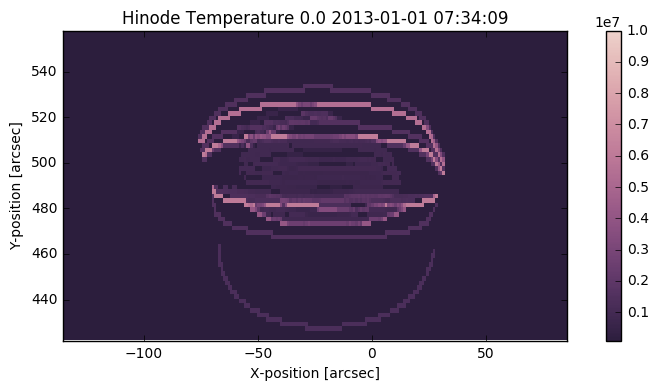

In [26]:
fig = plt.figure(figsize=(10,4))
ax = fig.gca()
vlos_map.plot(axes=ax,vmin=1e5,vmax=1e7)
plt.colorbar()

In [ ]:
observer.bin_detector_counts(ar_root)

Now let's take a look at a few of the EIS data cubes.

In [121]:
corner = (-25,485)*u.arcsec
width=10*u.arcsec
height=10*u.arcsec

In [134]:
eis.channels[0]

{'instrument_width': <Quantity 0.06 Angstrom>,
 'model_wavelengths': <Quantity [ 188.216] Angstrom>,
 'name': 'Fe_XI_188.232',
 'response': {'x': <Quantity [ 188.018, 188.041, 188.063, 188.085, 188.108, 188.13 , 188.152,
              188.174, 188.197, 188.219, 188.241, 188.264, 188.286, 188.308,
              188.331, 188.353, 188.375, 188.397, 188.42 , 188.442] Angstrom>,
  'y': <Quantity [  8.80045000e-12,  8.83443000e-12,  8.86846000e-12,
               8.90249000e-12,  8.93657000e-12,  8.97065000e-12,
               9.00475000e-12,  9.03889000e-12,  9.07306000e-12,
               9.10723000e-12,  9.14142000e-12,  9.17565000e-12,
               9.20988000e-12,  9.24414000e-12,  9.27841000e-12,
               9.31271000e-12,  9.34701000e-12,  9.38132000e-12,
               9.41568000e-12,  9.45002000e-12] cm2 ct sr / (ph pix)>},
 'spectral_resolution': <Quantity 0.0017 Angstrom>,
 'wavelength': <Quantity 188.232 Angstrom>,
 'wavelength_range': <Quantity [ 188.018, 188.442] Angstrom>

/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/sunpy/map/mapbase.py:1590: Warning: WCSAxes is installed but not being used. Plots may not have the expected behaviour.
  Warning)
/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/sunpy/map/mapbase.py:1590: Warning: WCSAxes is installed but not being used. Plots may not have the expected behaviour.
  Warning)
/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/sunpy/map/mapbase.py:1590: Warning: WCSAxes is installed but not being used. Plots may not have the expected behaviour.
  Warning)
/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/sunpy/map/mapbase.py:1590: Warning: WCSAxes is installed but not being used. Plots may not have the expected behaviour.
  Warning)


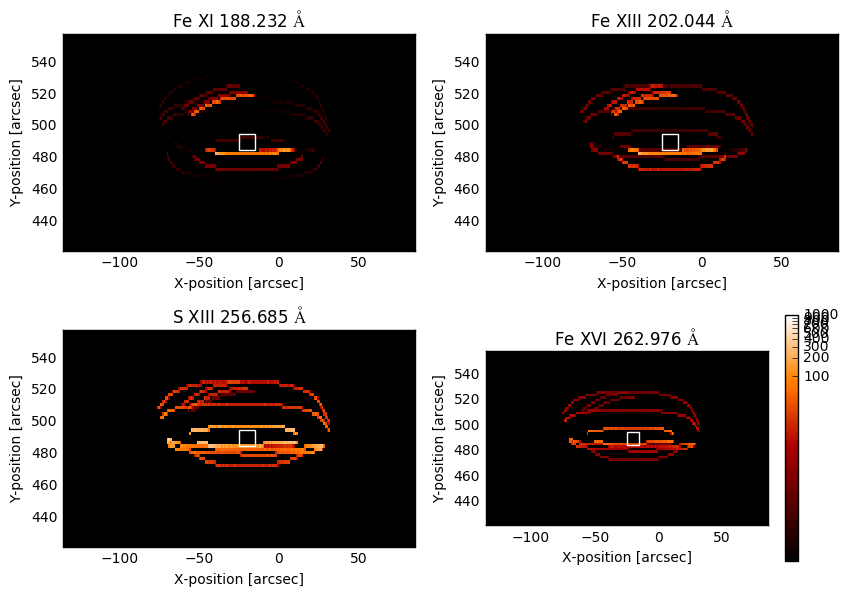

In [139]:
timestep = 145
fig,axes = plt.subplots(2,2,figsize=(10,7))
for channel,ax in zip(eis.channels,axes.flatten()):
    eis_cube = synthesizAR.util.EISCube(os.path.join(ar_root,eis.name,channel['name'],
                                                     'map_t{:06d}.fits'.format(timestep)))
    integrated_intensity_map = eis_cube.integrated_intensity
    integrated_intensity_map.plot(axes=ax,
                                      norm=matplotlib.colors.SymLogNorm(1e-5,vmin=0.1,vmax=1000),title=False)
    integrated_intensity_map.draw_rectangle(corner,width,height,axes=ax)
    el,ion,wvl = channel['name'].split('_')
    ax.set_title(r'{} {} {} $\mathrm{{\AA}}$'.format(el,ion,wvl))
plt.colorbar()

Try making a gif of the spatially-averaged spectral profile for an EIS channel.

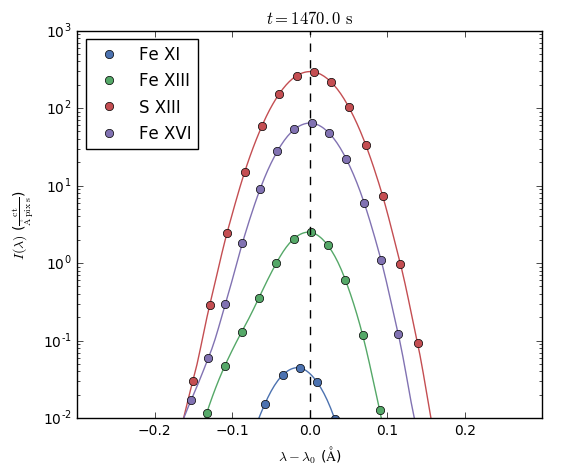

In [163]:
corner = (-25,485)*u.arcsec
width=10*u.arcsec
height=10*u.arcsec
fig = plt.figure(figsize=(6,5))
for t in [147]:#len(eis.observing_time)):
    ax = fig.add_subplot(111)
    for i,ec in enumerate(eis.channels):
        ff = os.path.join(ar_root,eis.name,ec['name'],'map_t{t:06d}.fits'.format(t=t))
        eis_cube = synthesizAR.util.EISCube(ff)
        
        #make spatial cut from the core
        ix,iy = eis_cube[0].data_to_pixel(corner[0],corner[1])
        ix,iy = int(np.round(ix.value)),int(np.round(iy.value))
        width_x,width_y = width/eis_cube[0].scale.x,height/eis_cube[0].scale.y
        width_x,width_y = int(np.round(width_x.value)),int(np.round(width_y.value))
        
        #slice and average
        spectral_profile = eis_cube.as_array()[iy:iy+width_y,ix:ix+width_x,:]
        spectral_profile = np.mean(np.mean(spectral_profile,axis=0),axis=0)
        
        #interpolate
        new_wvl = np.linspace(eis_cube.wavelength.value[0],eis_cube.wavelength.value[-1],200)
        f_interp = interp1d(eis_cube.wavelength.value,spectral_profile,kind='cubic')
        interp_profile = np.where(f_interp(new_wvl)<0,0,f_interp(new_wvl))
        
        #plot
        ax.plot(new_wvl-eis_cube.meta['wavelnth'],interp_profile,color=sns.color_palette('deep')[i])
        ax.plot(eis_cube.wavelength-eis_cube.meta['wavelnth']*u.angstrom,spectral_profile,
                marker='o',linestyle='',color=sns.color_palette('deep')[i],
               label=r'{}'.format(' '.join(ec['name'].split('_')[:-1])))
    ax.axvline(x=float(0.0),color='k',linestyle='--')
    ax.legend(loc=2,numpoints=1)
    ax.set_xlim([-0.3,0.3])
    ax.set_yscale('log')
    ax.set_ylim([1e-2,1e+3])
    ax.set_title(r'$t={}$ $\mathrm{{{}}}$'.format(eis.observing_time[t].value,eis.observing_time.unit))
    ax.set_ylabel(r'$I(\lambda)$ ({})'.format(
        u.Unit(eis_cube.meta['bunit']).compose(max_depth=1)[0].to_string(format='latex')))
    ax.set_xlabel(r'$\lambda-\lambda_0$ ($\mathrm{\AA}$)')
    #save
    #plt.savefig(os.path.join(ar_root,'figures','eis_spectra','eis_all_channels_t{:06d}.pdf'.format(t)))
    #clear figure
    #fig.clf()

In [ ]:
%%bash
convert -delay 10 -loop 0 /data/datadrive2/ar_viz/nei_testing/figures/eis_spectra/*.pdf eis_spectra.gif

In [44]:
HTML('<img src="eis_spectra.gif"/>')

In [179]:
test_ion = emiss_model.ions[1]['ion']

In [181]:
test_ion.meta

{'Dielectronic': False,
 'Element': 'fe',
 'Ion': 11,
 'Z': 26,
 'abundance_filename': 'sun_photospheric_2009_asplund',
 'filename': '/usr/local/ssw/packages/chianti/dbase/fe/fe_11/fe_11',
 'higher': 'fe_12',
 'lower': 'fe_10',
 'name': 'fe_11',
 'rcparams': {'abundfile': 'sun_photospheric_2009_asplund',
  'flux': 'photon',
  'gui': False,
  'ioneqfile': 'chianti',
  'wavelength': 'angstrom'},
 'spectroscopic_name': 'Fe XI'}

In [182]:
all_transitions = test_ion._read_chianti_db_h5('wgfa','wvl')

In [183]:
all_transitions = all_transitions[all_transitions>0]

In [185]:
eis.channels[0]

{'instrument_width': <Quantity 0.06 Angstrom>,
 'model_wavelengths': <Quantity [ 188.216] Angstrom>,
 'name': 'Fe_XI_188.232',
 'response': {'x': <Quantity [ 188.018, 188.041, 188.063, 188.085, 188.108, 188.13 , 188.152,
              188.174, 188.197, 188.219, 188.241, 188.264, 188.286, 188.308,
              188.331, 188.353, 188.375, 188.397, 188.42 , 188.442] Angstrom>,
  'y': <Quantity [  8.80045000e-12,  8.83443000e-12,  8.86846000e-12,
               8.90249000e-12,  8.93657000e-12,  8.97065000e-12,
               9.00475000e-12,  9.03889000e-12,  9.07306000e-12,
               9.10723000e-12,  9.14142000e-12,  9.17565000e-12,
               9.20988000e-12,  9.24414000e-12,  9.27841000e-12,
               9.31271000e-12,  9.34701000e-12,  9.38132000e-12,
               9.41568000e-12,  9.45002000e-12] cm2 ct sr / (ph pix)>},
 'spectral_resolution': <Quantity 0.0017 Angstrom>,
 'wavelength': <Quantity 188.232 Angstrom>,
 'wavelength_range': <Quantity [ 188.018, 188.442] Angstrom>

In [186]:
all_transitions[np.where(np.logical_and(all_transitions>=eis.channels[0]['wavelength_range'][0].value,
                        all_transitions<=eis.channels[0]['wavelength_range'][1].value))]

array([ 188.216,  188.299])

In [196]:
emiss_model.ions[0]['emissivity'][0].shape

(100, 100)

In [200]:
emiss_model._build_chianti_db_h5([{'name':'fe_9'}],os.path.join(ar_root,'chianti_db.h5'))

INFO:EmissionModel:Building entry for fe_9
INFO:EmissionModel:Building elvlc entry for fe_9
INFO:EmissionModel:Building wgfa entry for fe_9
INFO:EmissionModel:Building scups entry for fe_9
INFO:EmissionModel:Building psplups entry for fe_9


In [201]:
test_ion = synthesizAR.atomic.ChIon('fe_9',np.logspace(3,8,50)*u.K,np.logspace(8,11,50)/u.cm**3,
                                    os.path.join(ar_root,'chianti_db.h5'))

In [210]:
all_transitions = test_ion._read_chianti_db_h5('wgfa','wvl')
all_transitions = all_transitions[all_transitions>0]

In [206]:
aia = InstrumentSDOAIA([0,4990]*u.s,use_temperature_response_functions=False)

In [214]:
aia.channels[3]

{'gaussian_width': <Quantity 1.512 pix>,
 'instrument_label': 'AIA_2',
 'name': '193',
 'telescope_number': 2,
 'wavelength': <Quantity 193.0 Angstrom>,
 'wavelength_range': <Quantity [ 175., 215.] Angstrom>,
 'wavelength_response_spline_nots': (array([ 175. ,  175. ,  175. ,  175. ,  175.2,  175.3,  175.4,  175.5,
          175.6,  175.7,  175.8,  175.9,  176. ,  176.1,  176.2,  176.3,
          176.4,  176.5,  176.6,  176.7,  176.8,  176.9,  177. ,  177.1,
          177.2,  177.3,  177.4,  177.5,  177.6,  177.7,  177.8,  177.9,
          178. ,  178.1,  178.2,  178.3,  178.4,  178.5,  178.6,  178.7,
          178.8,  178.9,  179. ,  179.1,  179.2,  179.3,  179.4,  179.5,
          179.6,  179.7,  179.8,  179.9,  180. ,  180.1,  180.2,  180.3,
          180.4,  180.5,  180.6,  180.7,  180.8,  180.9,  181. ,  181.1,
          181.2,  181.3,  181.4,  181.5,  181.6,  181.7,  181.8,  181.9,
          182. ,  182.1,  182.2,  182.3,  182.4,  182.5,  182.6,  182.7,
          182.8,  182.9,  

In [220]:
len(all_transitions[np.where(np.logical_and(all_transitions>=80,
                        all_transitions<=350))])

186

In [222]:
np.random.rand(186,20,40)

array([[[ 0.52653397,  0.04782258,  0.61110236, ...,  0.92385184,
          0.19286408,  0.3523489 ],
        [ 0.61213938,  0.69629451,  0.9363088 , ...,  0.10816709,
          0.92004962,  0.8878073 ],
        [ 0.32005097,  0.42956282,  0.09193369, ...,  0.74720653,
          0.37825064,  0.36946133],
        ..., 
        [ 0.90513704,  0.3094869 ,  0.23524568, ...,  0.90197329,
          0.82382029,  0.77257758],
        [ 0.97009155,  0.7815948 ,  0.91332342, ...,  0.88765185,
          0.88499263,  0.59162315],
        [ 0.03341992,  0.10091578,  0.06102608, ...,  0.94614563,
          0.50130544,  0.87738219]],

       [[ 0.7070303 ,  0.03124107,  0.07986868, ...,  0.8814641 ,
          0.34490717,  0.32670687],
        [ 0.7571659 ,  0.07896811,  0.84351322, ...,  0.90653817,
          0.83088342,  0.2341768 ],
        [ 0.3035083 ,  0.91828789,  0.14286808, ...,  0.39998989,
          0.1703669 ,  0.77501987],
        ..., 
        [ 0.33515224,  0.31318899,  0.89647716, ...,